#Install

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install easyocr
!pip install opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#Imports

In [14]:
import os
import random
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
import cv2
import easyocr
import matplotlib.pyplot as plt
import glob


#Globals

In [15]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 2
BATCH_SIZE = 4

TRAIN_IMG_DIR = "/content/drive/MyDrive/archive/train/train"
TRAIN_ANNO_PATH = "/content/drive/MyDrive/archive/train/train/_annotations.csv"
VALID_IMG_DIR = "/content/drive/MyDrive/archive/valid/valid"
VALID_ANNO_PATH = "/content/drive/MyDrive/archive/valid/valid/_annotations.csv"



#Utils

In [16]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = int(max(widthA, widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = int(max(heightA, heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def get_plate_corners(box, image_shape, margin=0.08):
    xmin, ymin, xmax, ymax = box
    h, w = image_shape[:2]
    dx = (xmax - xmin) * margin
    dy = (ymax - ymin) * margin
    xmin = max(0, xmin - dx)
    xmax = min(w - 1, xmax + dx)
    ymin = max(0, ymin - dy)
    ymax = min(h - 1, ymax + dy)
    pts = np.array([
        [xmin, ymin], [xmax, ymin],
        [xmax, ymax], [xmin, ymax]
    ], dtype="float32")
    return pts


#Data

In [17]:
class PlateDetectionDataset(Dataset):
    def __init__(self, image_dir, csv_file, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms
        self.df = pd.read_csv(csv_file)
        self.df = self.df[self.df['class'] == 'License_Plate'].reset_index(drop=True)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['filename'])
        img = Image.open(img_path).convert("RGB")
        boxes = [[row['xmin'], row['ymin'], row['xmax'], row['ymax']]]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((1,), dtype=torch.int64)
        target = {
            'boxes': boxes.float(),
            'labels': labels.long(),
            'image_id': torch.tensor([idx]).long(),
        }
        if self.transforms:
            img = self.transforms(img)
        return img, target

    def __len__(self):
        return len(self.df)



#Network

In [18]:
# Network
from torchvision.models.detection import fasterrcnn_resnet50_fpn

def get_detection_model(num_classes=2):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes
    )
    return model



#Train

In [22]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")

def evaluate_loss(model, data_loader, device):
    model.train()
    total_loss = 0
    count = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            print(f"Loss type: {type(loss_dict)}")
            if isinstance(loss_dict, dict):
                losses = sum(loss for loss in loss_dict.values())
                total_loss += losses.item()
                count += 1
            elif isinstance(loss_dict, list):
                print("Tahmin döndü, loss hesaplanamadı!")
    print(f"total_loss: {total_loss}, count: {count}")
    return total_loss / (count if count > 0 else 1)



def random_search_lr(train_dataset, valid_dataset, batch_size=32, num_trials=5):
    learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
    best_val_loss = float('inf')
    best_lr = None

    for i in range(num_trials):
        lr = random.choice(learning_rates)
        print(f"\nTrial {i+1}/{num_trials}: LR={lr}, BatchSize={batch_size}")

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
        for i, (images, targets) in enumerate(valid_loader):
            print("Boxes dtype:", targets[0]['boxes'].dtype, targets[0]['boxes'])
            print("Labels dtype:", targets[0]['labels'].dtype, targets[0]['labels'])
            print("image_id dtype:", targets[0]['image_id'].dtype, targets[0]['image_id'])
            break

        model = get_detection_model(NUM_CLASSES)
        model.to(DEVICE)
        optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad], lr=lr, momentum=0.9, weight_decay=0.0005)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

        for epoch in range(2):
            train_one_epoch(model, optimizer, train_loader, DEVICE, epoch)
            lr_scheduler.step()

        val_loss = evaluate_loss(model, valid_loader, DEVICE)
        print(f"Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_lr = lr

    print("\n--- En iyi learning rate ---")
    print(f"Best LR: {best_lr}, Best validation loss: {best_val_loss:.4f}")
    return best_lr

best_lr = random_search_lr(train_dataset, valid_dataset, batch_size=BATCH_SIZE, num_trials=5)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
model = get_detection_model(NUM_CLASSES)
model.to(DEVICE)
optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad], lr=best_lr, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

print("\n--- En iyi learning rate ile FINAL MODEL EĞİTİMİ ---")
for epoch in range(5):
    train_one_epoch(model, optimizer, train_loader, DEVICE, epoch)
    lr_scheduler.step()




Trial 1/5: LR=5e-05, BatchSize=4
Boxes dtype: torch.float32 tensor([[181., 139., 216., 170.]])
Labels dtype: torch.int64 tensor([1])
image_id dtype: torch.int64 tensor([0])
Epoch 1 | Loss: 355.1639
Epoch 2 | Loss: 268.2388
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dict'>
Loss type: <class 'dic

#Test


--- TEST / OCR / GÖRSEL SONUÇ ---

Görsel: 00071c51c8e92a68_jpg.rf.446f345e7d5974082616d32dd8eb3d27.jpg
Plaka bulunamadı.


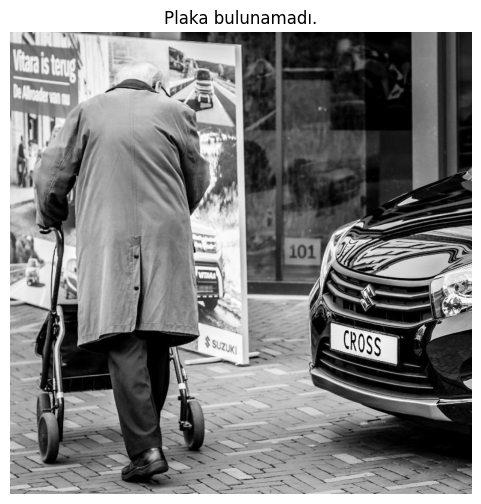


Görsel: 0011d11a6a5ab5ad_jpg.rf.1f1826e6aab333b74d8abb5073f16f30.jpg
Plate 1 BBox: [467.43594 519.1563  545.18    546.01807]
OCR: ['4493 JTA']


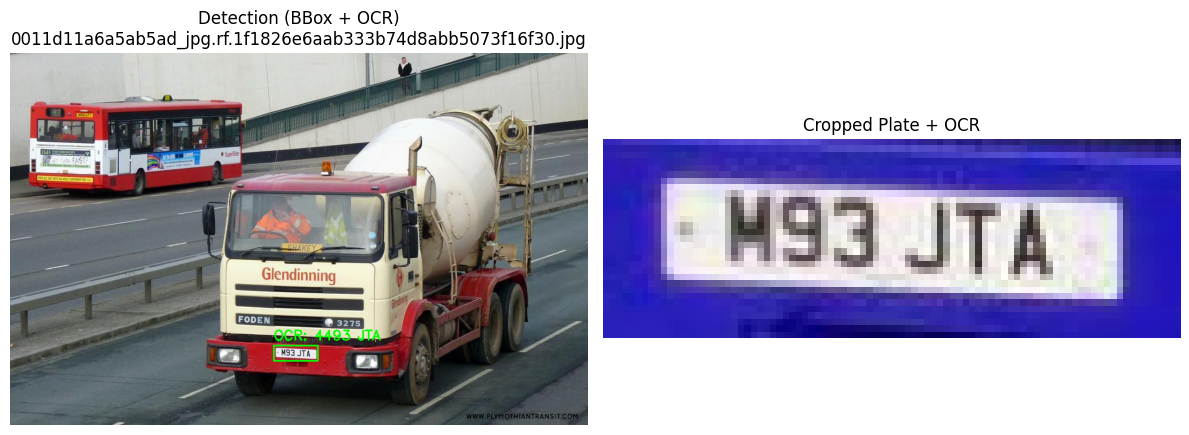


Görsel: 00166578c691cd43_jpg.rf.bfa1273a2ac2e2800ee4df0246d98980.jpg
Plate 1 BBox: [299.35095 712.06384 402.54654 741.5603 ]
OCR: ['Wb5o6']


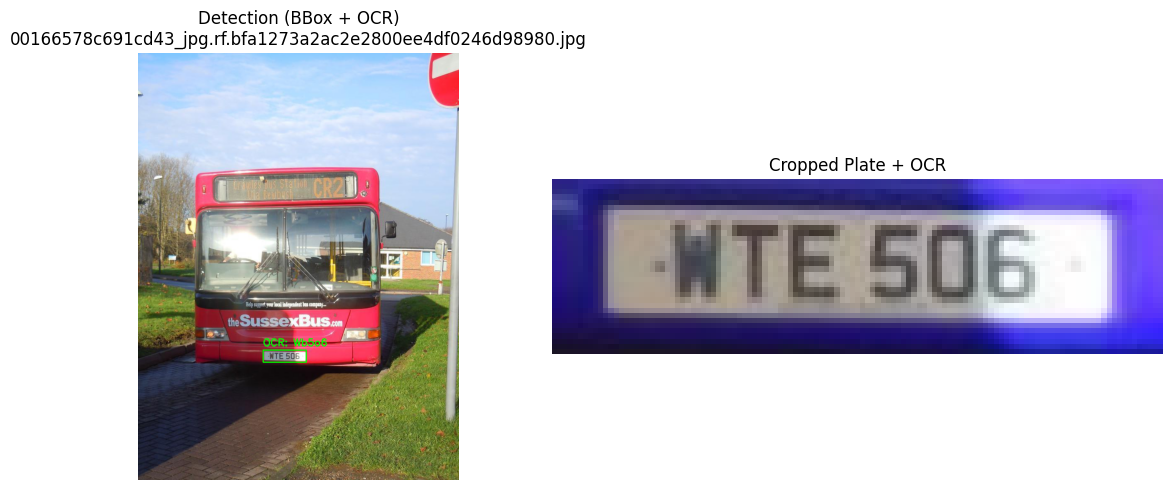


Görsel: 001679a19bb6fd3f_jpg.rf.2d93a7f26b44c5d3ef2cb219e2ecb403.jpg
Plaka bulunamadı.


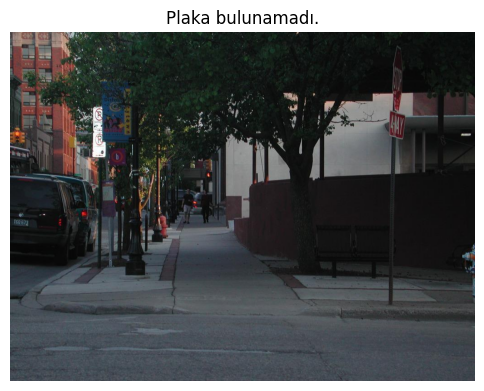


Görsel: 0021af0b921af690_jpg.rf.d33465c327a36942a50e3217c1f9fd45.jpg
Plaka bulunamadı.


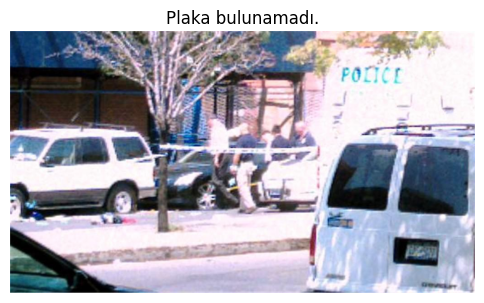

In [23]:
# Test + OCR + Görselleştirme
reader = easyocr.Reader(['en'])

def detect_and_reconstruct_plate(image_path, detection_model, device, conf_thresh=0.7):
    orig_img = Image.open(image_path).convert("RGB")
    np_img = np.array(orig_img)
    transform = T.ToTensor()
    img = transform(orig_img).to(device)
    detection_model.eval()
    with torch.no_grad():
        preds = detection_model([img])
    boxes = preds[0]['boxes']
    scores = preds[0]['scores']
    results = []
    for i, score in enumerate(scores):
        if score > conf_thresh:
            box = boxes[i].cpu().numpy()
            pts = get_plate_corners(box, np_img.shape)
            warped_plate = four_point_transform(np_img, pts)
            ocr_result = reader.readtext(warped_plate, detail=0)
            results.append((box, warped_plate, ocr_result))
    return results

print("\n--- TEST / OCR / GÖRSEL SONUÇ ---")
image_list = sorted(glob.glob(os.path.join(VALID_IMG_DIR, "*.jpg")))[:5]

for test_img_path in image_list:
    print(f"\nGörsel: {os.path.basename(test_img_path)}")
    results = detect_and_reconstruct_plate(test_img_path, model, DEVICE)
    orig_img = np.array(Image.open(test_img_path).convert("RGB"))

    if len(results) == 0:
        print("Plaka bulunamadı.")
        plt.figure(figsize=(6,6))
        plt.imshow(orig_img)
        plt.title("Plaka bulunamadı.")
        plt.axis("off")
        plt.show()
        continue

    for i, (box, plate_img, ocr_text) in enumerate(results):
        print(f"Plate {i+1} BBox: {box}")
        print(f"OCR: {ocr_text}")
        cv2.imwrite(f"plate_{i+1}_reconstructed.jpg", plate_img)

        # Orijinal görüntüye bbox çiz
        img_show = orig_img.copy()
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img_show, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img_show, f"OCR: {''.join(ocr_text)}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.imshow(img_show)
        plt.title(f"Detection (BBox + OCR)\n{os.path.basename(test_img_path)}")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
        plt.title("Cropped Plate + OCR")
        plt.xlabel(f"OCR: {''.join(ocr_text)}")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


#Dataset_Size

In [32]:
# Veri yolları
TRAIN_IMG_DIR = "/content/drive/MyDrive/archive/train/train"
TRAIN_ANNO_PATH = "/content/drive/MyDrive/archive/train/train/_annotations.csv"
VALID_IMG_DIR = "/content/drive/MyDrive/archive/valid/valid"
VALID_ANNO_PATH = "/content/drive/MyDrive/archive/valid/valid/_annotations.csv"
TEST_IMG_DIR = "/content/drive/MyDrive/archive/test/test"
TEST_ANNO_PATH = "/content/drive/MyDrive/archive/test/test/_annotations.csv"

# Datasetleri oluştur
train_dataset = PlateDetectionDataset(TRAIN_IMG_DIR, TRAIN_ANNO_PATH, transforms=None)
valid_dataset = PlateDetectionDataset(VALID_IMG_DIR, VALID_ANNO_PATH, transforms=None)
test_dataset  = PlateDetectionDataset(TEST_IMG_DIR, TEST_ANNO_PATH, transforms=None)

# Sample sayılarını ekrana yazdır
print(f"Train dataset sample count: {len(train_dataset)}")
print(f"Validation dataset sample count: {len(valid_dataset)}")
print(f"Test dataset sample count: {len(test_dataset)}")


Train dataset sample count: 7357
Validation dataset sample count: 2195
Test dataset sample count: 1085


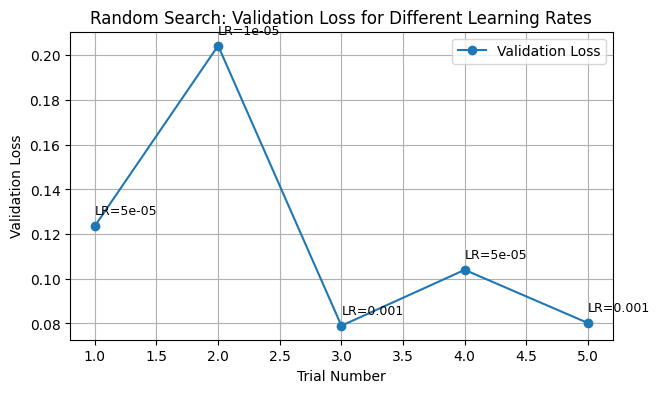

In [33]:
import matplotlib.pyplot as plt

# Denemeler için örnek veri (senin sonuçların)
trials = [1, 2, 3, 4, 5]
learning_rates = [5e-5, 1e-5, 0.001, 5e-5, 0.001]
val_losses = [0.1236, 0.2043, 0.0790, 0.1040, 0.0802]

plt.figure(figsize=(7,4))
plt.plot(trials, val_losses, marker='o', linestyle='-', label='Validation Loss')
for i, lr in enumerate(learning_rates):
    plt.text(trials[i], val_losses[i]+0.005, f"LR={lr}", fontsize=9)
plt.xlabel('Trial Number')
plt.ylabel('Validation Loss')
plt.title('Random Search: Validation Loss for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()


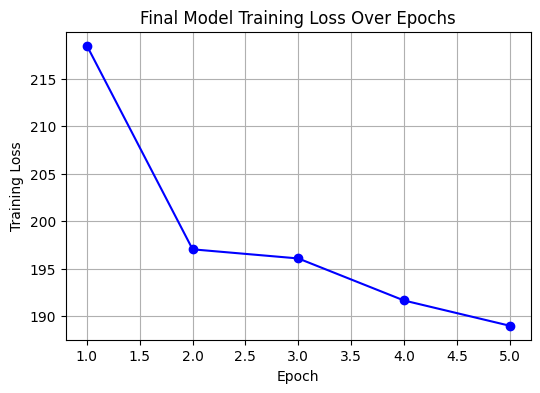

In [34]:
epochs = [1, 2, 3, 4, 5]
train_loss = [218.4648, 197.0450, 196.0852, 191.6638, 189.0075]

plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss, marker='o', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Final Model Training Loss Over Epochs')
plt.grid(True)
plt.show()
